# 1. EDA

In [1]:
import os
import os.path as osp
import numpy as np
from IPython.display import display
from PIL import Image
import time
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

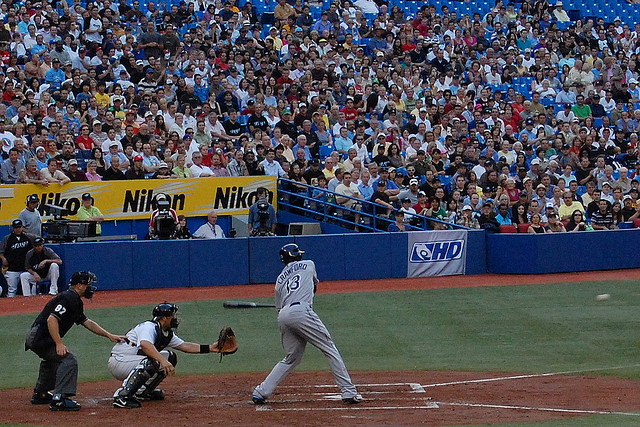

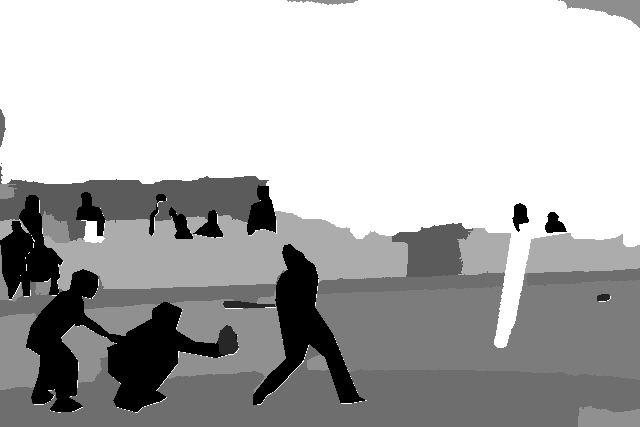

[  0  36  38  39  91 104 110 124 142 144 172 255]


In [2]:
train_input_dir = "/kaggle/input/aio-coco-stuff/train2017/train2017"
train_label_dir = "/kaggle/input/aio-coco-stuff/stuffthingmaps_trainval2017/train2017"
val_input_dir = "/kaggle/input/aio-coco-stuff/val2017/val2017"
val_label_dir = "/kaggle/input/aio-coco-stuff/stuffthingmaps_trainval2017/val2017"

sample_index = 102


sample_train_input = sorted(os.listdir(train_input_dir))[sample_index]
sample_train_input_path = osp.join(train_input_dir, sample_train_input)
input_img = Image.open(sample_train_input_path)
display(input_img)
# input_array = np.array(input_img)
# input_values = np.unique(input_array)
# print(input_values)

sample_train_label = sorted(os.listdir(train_label_dir))[sample_index]
sample_train_label_path = osp.join(train_label_dir, sample_train_label)
label_img = Image.open(sample_train_label_path)
display(label_img)
label_array = np.array(label_img)
label_values = np.unique(label_array)
print(label_values)

In [3]:
print(len(os.listdir(train_input_dir)))
print(len(os.listdir(val_input_dir)))

118287
5000


In [7]:
def visualize_image_size(val_input_dir):
    heights = []
    widths = []
    for i in tqdm(sorted(os.listdir(val_input_dir))):
        sample_val_input_path = osp.join(val_input_dir, i)
        input_img = Image.open(sample_val_input_path)
        input_img = np.array(input_img)
        heights.append(input_img.shape[0])
        widths.append(input_img.shape[1])
        if input_img.shape[2] != 3:
            print(sample_val_input_path)

    plt.figure(figsize=(8, 6))
    plt.scatter(widths, heights, c='red', alpha=0.5, marker='o', edgecolors='black', linewidths=1.5)
    plt.xlabel('Width')
    plt.ylabel('Height')
    plt.grid(True)
    plt.show()

In [5]:
# visualize_image_size(train_input_dir)

In [8]:
visualize_image_size(val_input_dir)

  2%|▏         | 80/5000 [00:00<00:46, 106.23it/s]


IndexError: tuple index out of range

# 2. Dataset & DataLoader

In [9]:
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch
from skimage import color

WIDTH = 256
HEIGHT = 256

class ColorDataset(Dataset):
    def __init__(self, data_root):
        self.data_root = data_root
        self.file_list = os.listdir(self.data_root)

    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, index):
        img = cv2.cvtColor(cv2.imread(osp.join(self.data_root, self.file_list[index])), cv2.COLOR_BGR2RGB)
        resized_img_lab = cv2.resize(img, (WIDTH, HEIGHT)) # resize image to network input size
        img_lab = torch.FloatTensor(np.transpose(color.rgb2lab(np.array(resized_img_lab)), (2, 0, 1)))
        img_ab = img_lab[1:3, :, :]
        img_l = img_lab[0, :, :].unsqueeze(0)
        return img_l, img_ab

In [10]:
# Create a transform variable
transform = transforms.Compose([
    transforms.RandomAdjustSharpness(sharpness_factor=2),  # Randomly adjust sharpness
    transforms.ColorJitter(brightness=0.5, contrast=0.5),  # Randomly enhance color (brightness and contrast)
    transforms.RandomHorizontalFlip(),  # Randomly flip horizontally
    transforms.RandomRotation(degrees=45),  # Randomly rotate (assume rotation angle is 45 degrees)
    transforms.RandomResizedCrop(size=(256, 256), scale=(0.8, 1.2)),  # Randomly crop and resize
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),  # Randomly translate
])

train_dataset = ColorDataset(train_input_dir)
val_dataset = ColorDataset(val_input_dir)

train_batch_size = 64
test_batch_size = 8
num_workers = 4

train_loader = DataLoader(train_dataset, batch_size=train_batch_size, num_workers=num_workers, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=test_batch_size, num_workers=num_workers, shuffle=False)

In [11]:
%%time
temp = iter(train_loader)
# print(model(next(temp)[0]).shape)
print(next(temp)[0].shape)
print(next(temp)[1].shape)

torch.Size([64, 1, 256, 256])
torch.Size([64, 2, 256, 256])
CPU times: user 40.7 ms, sys: 59.4 ms, total: 100 ms
Wall time: 2.89 s


# 3. Model

In [12]:
import torch.nn as nn

class BaseColor(nn.Module):
    def __init__(self):
        super(BaseColor, self).__init__()

        self.l_cent = 50.
        self.l_norm = 100.
        self.ab_norm = 110.

    def normalize_l(self, in_l):
        return (in_l-self.l_cent)/self.l_norm

    def unnormalize_l(self, in_l):
        return in_l*self.l_norm + self.l_cent

    def normalize_ab(self, in_ab):
        return in_ab/self.ab_norm

    def unnormalize_ab(self, in_ab):
        return in_ab*self.ab_norm

In [13]:
class ECCVGenerator(BaseColor):
    def __init__(self, norm_layer=nn.BatchNorm2d):
        super(ECCVGenerator, self).__init__()

        model1=[nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=True),]
        model1+=[nn.ReLU(True),]
        model1+=[nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1, bias=True),]
        model1+=[nn.ReLU(True),]
        model1+=[norm_layer(64),]

        model2=[nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=True),]
        model2+=[nn.ReLU(True),]
        model2+=[nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1, bias=True),]
        model2+=[nn.ReLU(True),]
        model2+=[norm_layer(128),]

        model3=[nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model3+=[nn.ReLU(True),]
        model3+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model3+=[nn.ReLU(True),]
        model3+=[nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1, bias=True),]
        model3+=[nn.ReLU(True),]
        model3+=[norm_layer(256),]

        model4=[nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model4+=[nn.ReLU(True),]
        model4+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model4+=[nn.ReLU(True),]
        model4+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model4+=[nn.ReLU(True),]
        model4+=[norm_layer(512),]

        model5=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model5+=[nn.ReLU(True),]
        model5+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model5+=[nn.ReLU(True),]
        model5+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model5+=[nn.ReLU(True),]
        model5+=[norm_layer(512),]

        model6=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model6+=[nn.ReLU(True),]
        model6+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model6+=[nn.ReLU(True),]
        model6+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model6+=[nn.ReLU(True),]
        model6+=[norm_layer(512),]

        model7=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model7+=[nn.ReLU(True),]
        model7+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model7+=[nn.ReLU(True),]
        model7+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model7+=[nn.ReLU(True),]
        model7+=[norm_layer(512),]

        model8=[nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=True),]
        model8+=[nn.ReLU(True),]
        model8+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model8+=[nn.ReLU(True),]
        model8+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model8+=[nn.ReLU(True),]

        model8+=[nn.Conv2d(256, 313, kernel_size=1, stride=1, padding=0, bias=True),]

        self.model1 = nn.Sequential(*model1)
        self.model2 = nn.Sequential(*model2)
        self.model3 = nn.Sequential(*model3)
        self.model4 = nn.Sequential(*model4)
        self.model5 = nn.Sequential(*model5)
        self.model6 = nn.Sequential(*model6)
        self.model7 = nn.Sequential(*model7)
        self.model8 = nn.Sequential(*model8)

        self.softmax = nn.Softmax(dim=1)
        self.model_out = nn.Conv2d(313, 2, kernel_size=1, padding=0, dilation=1, stride=1, bias=False)
        self.upsample4 = nn.Upsample(scale_factor=4, mode='bilinear')

    def forward(self, input_l):
        input_l = self.model1(self.normalize_l(input_l))
        input_l = self.model2(input_l)
        input_l = self.model3(input_l)
        input_l = self.model4(input_l)
        input_l = self.model5(input_l)
        input_l = self.model6(input_l)
        input_l = self.model7(input_l)
        input_l = self.model8(input_l)
        input_l = self.model_out(self.softmax(input_l))

        return self.unnormalize_ab(self.upsample4(input_l))

In [14]:
!pip install torchsummary

In [15]:
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ECCVGenerator().to(device)
summary(model, (1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]             640
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 128, 128]          36,928
              ReLU-4         [-1, 64, 128, 128]               0
       BatchNorm2d-5         [-1, 64, 128, 128]             128
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
              ReLU-9          [-1, 128, 64, 64]               0
      BatchNorm2d-10          [-1, 128, 64, 64]             256
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,080
             ReLU-14          [-1, 256,

# 4. Loss & Optimizer

In [16]:
lr = 1e-3
epochs = 50

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr
)


# 5. Train

In [ ]:
!pip install wandb

In [17]:
import wandb
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
wandb_api = user_secrets.get_secret("wandb_api") 
wandb.login(key=wandb_api)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [18]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            # _, predicted = torch.max(outputs.data, 1)
            # total += labels.size(0)
            # correct += (predicted == labels).sum().item()

    loss = sum(losses) / len(losses)
    # acc = correct / total # not classifier, so dont have accuracy

    return loss


In [21]:
def fit(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    wandb.init(
        # set the wandb project where this run will be logged
        project="zhang-train-reg",

        # track hyperparameters and run metadata
        config={
        "dataset": "coco-stuff",
        "architecture": "ECCV",
        "criterion": "MSE",
        "optimizer": "Adam",
        "epochs": 50,
        "lr": lr
        }
    )
    
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []

        model.train()
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            batch_train_losses.append(loss.item())
            wandb.log({"batch_train_loss": loss})
            if train_batch_size * len(batch_train_losses) > 10000:
                break

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        
        wandb.log({"train_loss": train_loss, "val_loss": val_loss})

        print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}')

    return train_losses, val_losses

In [ ]:
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs
)

batch_train_loss,▅▂▄▄▆▃▅▂▃▄▆▄▃▃▃▂▇▃▄▁▄▄▇▄█▄▃▅▃▃▄▄▃▅▆▁▃▇▄▆
batch_train_loss,240.33029


EPOCH 1:	Train loss: 211.9666	Val loss: 211.8424
EPOCH 2:	Train loss: 209.6798	Val loss: 209.0998
EPOCH 3:	Train loss: 206.1418	Val loss: 208.3847
EPOCH 4:	Train loss: 205.8063	Val loss: 205.5176
EPOCH 5:	Train loss: 201.0846	Val loss: 199.6827
EPOCH 6:	Train loss: 198.5585	Val loss: 199.7243
EPOCH 7:	Train loss: 203.2605	Val loss: 200.8162
EPOCH 8:	Train loss: 197.4302	Val loss: 197.3209
EPOCH 9:	Train loss: 198.0966	Val loss: 195.6539
EPOCH 10:	Train loss: 195.7481	Val loss: 205.4222
EPOCH 11:	Train loss: 192.4804	Val loss: 191.6488
EPOCH 12:	Train loss: 189.5551	Val loss: 193.0358
EPOCH 13:	Train loss: 189.8358	Val loss: 190.3708
EPOCH 14:	Train loss: 189.7056	Val loss: 193.6386
EPOCH 15:	Train loss: 186.4247	Val loss: 190.6606
EPOCH 16:	Train loss: 187.0821	Val loss: 188.5445
EPOCH 17:	Train loss: 187.2908	Val loss: 188.6185
EPOCH 18:	Train loss: 188.0236	Val loss: 187.0932
EPOCH 19:	Train loss: 185.8106	Val loss: 192.5230
EPOCH 20:	Train loss: 187.3091	Val loss: 190.9365
EPOCH 21:

# 6. Eval